In [1]:
import cv2
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../../PRNet")
from api import PRN
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '' # cpu
prn = PRN(is_dlib = True, prefix="../../PRNet")
from utils.render import render_texture
from utils.rotate_vertices import frontalize
from utils.estimate_pose import estimate_pose
import numpy as np

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use `layer.__call__` method instead.





INFO:tensorflow:Restoring parameters from ../../PRNet/Data/net-data/256_256_resfcn256_weight


In [21]:
import time
def warp_face(img_in, img_ref):
    #img_in is HD image
    # img_ref is synthesis image
    # Calculate position map and get pose and rotation matrix
    pos1 = prn.process(img_in) 
    vertices1 = prn.get_vertices(pos1)
    cam_mat1, pose1, R1 = estimate_pose(vertices1)
    pos2 = prn.process(img_ref) 
    vertices2 = prn.get_vertices(pos2)
    cam_mat2, pose2, R2 = estimate_pose(vertices2)

    # Rotation 3D vertices
    warp_vertices = np.matmul(np.matmul(vertices2,R2), np.linalg.inv(R1)) 

    # Do translation
    center2_warp_pt = np.mean(warp_vertices, axis=0)
    center1_pt = np.mean(vertices1, axis=0)
    warp_vertices = warp_vertices - (center2_warp_pt - center1_pt)

    # Render new synthesis image after doing transformation
    # t1 = time.time()
    texture_ref = cv2.remap(img_ref/255.0, pos2[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
    # print("Texture from pos map: ", time.time()-t1)

    [h, w, c] = img_ref.shape
    # t1 = time.time()
    
    color = prn.get_colors_from_texture(texture_ref)
    # print("Get color of texture: ", time.time()-t1)
    
    color_mask = np.ones((warp_vertices.shape[0], 1))
    t1 = time.time()
    new_image = render_texture(warp_vertices.T, color.T, prn.triangles.T, h, w, c = 3)
    print("Time render: ", time.time()-t1)
    facemask = render_texture(warp_vertices.T, color_mask.T, prn.triangles.T, h, w, c = 3)

    # Using seamlessCloning to blending images
    vis_ind = np.argwhere(facemask>0)
    vis_min = np.min(vis_ind, 0)
    vis_max = np.max(vis_ind, 0)
    center = (int((vis_min[1] + vis_max[1])/2+0.5), int((vis_min[0] + vis_max[0])/2+0.5))
    output = cv2.seamlessClone((new_image*255).astype(np.uint8),(img_in).astype(np.uint8), (facemask*255).astype(np.uint8), center, cv2.NORMAL_CLONE)

    return output



In [5]:
sys.path.insert(0, "../Face-Super-Resolution/models")
import argparse
import torch
from PIL import Image
import torchvision.transforms as transforms
from models.SRGAN_model import SRGANModel

def get_FaceSR_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('--gpu_ids', type=str, default=None)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--lr_G', type=float, default=1e-4)
    parser.add_argument('--weight_decay_G', type=float, default=0)
    parser.add_argument('--beta1_G', type=float, default=0.9)
    parser.add_argument('--beta2_G', type=float, default=0.99)
    parser.add_argument('--lr_D', type=float, default=1e-4)
    parser.add_argument('--weight_decay_D', type=float, default=0)
    parser.add_argument('--beta1_D', type=float, default=0.9)
    parser.add_argument('--beta2_D', type=float, default=0.99)
    parser.add_argument('--lr_scheme', type=str, default='MultiStepLR')
    parser.add_argument('--niter', type=int, default=100000)
    parser.add_argument('--warmup_iter', type=int, default=-1)
    parser.add_argument('--lr_steps', type=list, default=[50000])
    parser.add_argument('--lr_gamma', type=float, default=0.5)
    parser.add_argument('--pixel_criterion', type=str, default='l1')
    parser.add_argument('--pixel_weight', type=float, default=1e-2)
    parser.add_argument('--feature_criterion', type=str, default='l1')
    parser.add_argument('--feature_weight', type=float, default=1)
    parser.add_argument('--gan_type', type=str, default='ragan')
    parser.add_argument('--gan_weight', type=float, default=5e-3)
    parser.add_argument('--D_update_ratio', type=int, default=1)
    parser.add_argument('--D_init_iters', type=int, default=0)

    parser.add_argument('--print_freq', type=int, default=100)
    parser.add_argument('--val_freq', type=int, default=1000)
    parser.add_argument('--save_freq', type=int, default=10000)
    parser.add_argument('--crop_size', type=float, default=0.85)
    parser.add_argument('--lr_size', type=int, default=128)
    parser.add_argument('--hr_size', type=int, default=512)

    # network G
    parser.add_argument('--which_model_G', type=str, default='RRDBNet')
    parser.add_argument('--G_in_nc', type=int, default=3)
    parser.add_argument('--out_nc', type=int, default=3)
    parser.add_argument('--G_nf', type=int, default=64)
    parser.add_argument('--nb', type=int, default=16)

    # network D
    parser.add_argument('--which_model_D', type=str, default='discriminator_vgg_128')
    parser.add_argument('--D_in_nc', type=int, default=3)
    parser.add_argument('--D_nf', type=int, default=64)

    # data dir
    parser.add_argument('--pretrain_model_G', type=str, default='checkpoints/30000_G_our.pth')
    parser.add_argument('--pretrain_model_D', type=str, default=None)

    args = parser.parse_args()

    return args


sr_model = SRGANModel(get_FaceSR_opt(), is_train=False)
sr_model.load()


ModuleNotFoundError: No module named 'models'

# Warp video 3D with highres

In [2]:
import cv2
cap_synthesis = cv2.VideoCapture("../resultdeenglish.mp4")


True

# Generate output

In [7]:
from tqdm import tqdm
for i in tqdm(range(1, 150)): 
    img_in = cv2.imread(f"/home/vuthede/Desktop/3D/input/{i}.png")
    img_ref = cv2.imread(f"/home/vuthede/Desktop/3D/ref/{i}.png")

    out = warp_face(img_in, img_ref)
    cv2.imwrite(f"/home/vuthede/Desktop/3D/output_swap_3d/{i}.png", out)
    print(f"Finish warping {i}-th frame")


0%|          | 0/149 [00:00<?, ?it/s]Here is input:  (565, 565, 3)
Here is input:  (565, 565, 3)
  1%|          | 1/149 [00:21<52:47, 21.40s/it]Finish warping 1-th frame
Here is input:  (565, 565, 3)
Here is input:  (565, 565, 3)
  1%|▏         | 2/149 [00:43<53:07, 21.69s/it]Finish warping 2-th frame
Here is input:  (565, 565, 3)
Here is input:  (565, 565, 3)
  2%|▏         | 3/149 [01:06<53:16, 21.90s/it]Finish warping 3-th frame
Here is input:  (565, 565, 3)
Here is input:  (565, 565, 3)
  3%|▎         | 4/149 [01:28<53:07, 21.98s/it]Finish warping 4-th frame
Here is input:  (565, 565, 3)
Here is input:  (565, 565, 3)
  3%|▎         | 5/149 [01:50<52:48, 22.01s/it]Finish warping 5-th frame
Here is input:  (565, 565, 3)
Here is input:  (565, 565, 3)
  4%|▍         | 6/149 [02:12<52:33, 22.05s/it]Finish warping 6-th frame
Here is input:  (565, 565, 3)
Here is input:  (565, 565, 3)
  5%|▍         | 7/149 [02:34<52:04, 22.00s/it]Finish warping 7-th frame
Here is input:  (565, 565, 3)
He

In [8]:
def merge_frames():
    syn_dir = "/home/vuthede/Desktop/3D/input/"
    full_hd_dir = "/home/vuthede/Desktop/3D/ref/"
    warping_dir = "/home/vuthede/Desktop/3D/output_swap_3d/"
    out = cv2.VideoWriter('/home/vuthede/Desktop/3D/out3d.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (565*3, 565))
    for i in range(1,150):
        im1 = cv2.imread(syn_dir+f"{i}.png")
        im2 = cv2.imread(full_hd_dir+f"{i}.png")
        im3 = cv2.imread(warping_dir+f"{i}.png")

        concat = np.hstack([im1, im2, im3])
        out.write(concat)

        print(concat.shape)
        cv2.imshow("Concat", concat)
        k = cv2.waitKey(0)

        if k ==27:
            break

    out.release()

merge_frames()

(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695, 3)
(565, 1695

# Demo one image

In [18]:
import time
def warp_face2(img_in, img_ref):
    #img_in is HD image
    # img_ref is synthesis image
    # Calculate position map and get pose and rotation matrix
    pos1 = prn.process(img_in) 
    vertices1 = prn.get_vertices(pos1)
    cam_mat1, pose1, R1 = estimate_pose(vertices1)
    pos2 = prn.process(img_ref) 
    vertices2 = prn.get_vertices(pos2)
    cam_mat2, pose2, R2 = estimate_pose(vertices2)

    # Rotation 3D vertices
    warp_vertices = np.matmul(np.matmul(vertices2,R2), np.linalg.inv(R1)) 

    # Do translation
    center2_warp_pt = np.mean(warp_vertices, axis=0)
    center1_pt = np.mean(vertices1, axis=0)
    warp_vertices = warp_vertices - (center2_warp_pt - center1_pt)

    # Render new synthesis image after doing transformation
    # t1 = time.time()
    texture_ref = cv2.remap(img_ref/255.0, pos2[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))



    # # print("Texture from pos map: ", time.time()-t1)

    [h, w, c] = img_ref.shape
    # # t1 = time.time()
    
    color = prn.get_colors_from_texture(texture_ref)
    # warp_color = np.matmul(np.matmul(color,R2), np.linalg.inv(R1)) 
    # warp_color = warp_color - (center2_warp_pt - center1_pt)

    # # print("Get color of texture: ", time.time()-t1)
    
    # t1 = time.time()
    new_image = render_texture(warp_vertices.T, color.T, prn.triangles.T, h, w, c = 3)
    new_image = (new_image*255).astype(np.uint8)

    pos3 = prn.process(new_image) 
    vertices3 = prn.get_vertices(pos3)
    texture_ref3 = cv2.remap(new_image/255.0, pos3[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
    color3 = prn.get_colors_from_texture(texture_ref3)
    new_image3 = render_texture(vertices3.T, color3.T, prn.triangles.T, h, w, c = 3)

    

    # color_mask = np.ones((warp_vertices.shape[0], 1))

    # # print("Time render: ", time.time()-t1)
    # facemask = render_texture(vertices3.T, color_mask.T, prn.triangles.T, h, w, c = 3)

    # # # Using seamlessCloning to blending images
    # vis_ind = np.argwhere(facemask>0)
    # vis_min = np.min(vis_ind, 0)
    # vis_max = np.max(vis_ind, 0)
    # center = (int((vis_min[1] + vis_max[1])/2+0.5), int((vis_min[0] + vis_max[0])/2+0.5))
    # output = cv2.seamlessClone((new_image3*255).astype(np.uint8),(img_in).astype(np.uint8), (facemask*255).astype(np.uint8), center, cv2.NORMAL_CLONE)

    return output


Time render:  8.22774887084961


Text(0.5, 1.0, 'Output1')

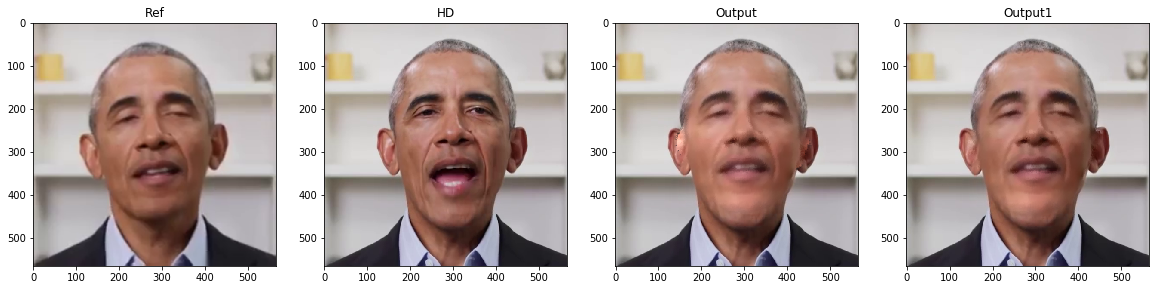

In [23]:
img_in = cv2.imread("/home/vuthede/Desktop/3D/5_in.png")
img_ref = cv2.imread("/home/vuthede/Desktop/3D/5_ref.png") 

output = warp_face2(img_in, img_ref)
output1 = warp_face(img_in, img_ref)


fig, ax = plt.subplots(1,4,figsize=(20,5))
ax[1].imshow(img_in[:,:,::-1])
ax[1].set_title("HD")
ax[0].imshow(img_ref[:,:,::-1])
ax[0].set_title("Ref")
ax[2].imshow(output[:,:,::-1])
ax[2].set_title("Output")
ax[3].imshow(output1[:,:,::-1])
ax[3].set_title("Output1")